# Présentation du kernel

Notebook tiré du kernel kaggle [https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras](). Pour plus de commentaires et d'explications, ne pas hésiter à aller voir sur le site.

Modèle de réseaux de neurones avec Keras, utilisant successivement :
- 1 couche d'embeddings
- 1 couche LSTM
- max pooling
- 2 couches denses (avec dropout)

# Importation des données

import Python

In [3]:
import sys
import os
import re
import csv
import codecs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, model_from_json
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


Chargement et affichage des données

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Séparation des labels et des commentaires

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

# Prétraitement du texte et conversion en données numériques

### Tokenization des phrases en mots, et conversions en listes d'indices

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [7]:
# tokenizer.word_counts  # counts of each word
# tokenizer.word_index   # dict mapping vocab to index

### Padding des phrases trop courtes, et troncature des phrases trop longues.

In [9]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Pourquoi se limiter à 200 mots?

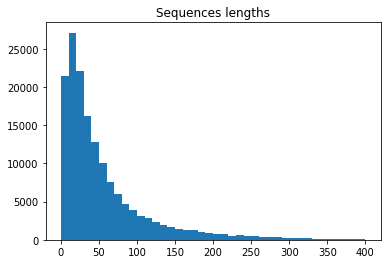

In [12]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title("Sequences lengths")
plt.show()

# Construction du modèle

- Input (None, 200)
- Embedding (None, 200, 128)
- LSTM (None, 200, 60)
- Max Pooling (None, 60)
- Dropout (None, 60)
- Dense (None, 50)
- Dropout (None, 50)
- Dense (None, 6)

In [9]:
# input
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

# embedding
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

# LSTM
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

# max pooling 1D
x = GlobalMaxPool1D()(x)

# dropout 1
x = Dropout(0.1)(x)

# dense 1
x = Dense(50, activation="relu")(x)

# dropout 2
x = Dropout(0.1)(x)

# dense 1
x = Dense(6, activation="sigmoid")(x)

In [30]:
# load json and create model
with open("../models/embed_lstm_2fc.json", "r") as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("../models/embed_lstm_2fc.h5")
print("Loaded model from disk")

Loaded model from disk


In [10]:
# nnet declaration
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [11]:
# train
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 840s 6ms/step - loss: 0.0653 - acc: 0.9778 - val_loss: 0.0493 - val_acc: 0.9821
Epoch 2/2
143613/143613 [==============================] - 899s 6ms/step - loss: 0.0450 - acc: 0.9831 - val_loss: 0.0468 - val_acc: 0.9825


In [31]:
model.evaluate(X_t, y)

159571/159571 [==============================] - 158s 988us/step


[0.03809344222148182, 0.98518108633028]

# Save model and weights

In [27]:
# serialize model to JSON
model_json = model.to_json()
with open("../models/embed_lstm_2fc.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../models/embed_lstm_2fc.h5")
print("Saved model to disk")

Saved model to disk
